In [ ]:
# These comments help explain some of the code and its function. The first time a tool is used on a computer.
# The first time this tool is run on a computer run this box and restart the page.

!pip install openai

In [4]:
import pandas as pd

# Load the Excel file
xl = pd.ExcelFile("LME Approved Brands (2).xlsx")

# Get the sheet names
sheet_names = xl.sheet_names
sheet_names

['Copper - Grade A',
 'Lead',
 'Special High Grade Zinc',
 'Tin',
 'Primary Nickel',
 'High Grade Primary Aluminium',
 'Aluminium Alloy',
 'NASAAC',
 'Cobalt']

In [5]:
# A dictionary to hold the dataframes
dataframes = {}

# Loop over the sheet names, loading and cleaning each one
for sheet_name in sheet_names:
    df = pd.read_excel("LME Approved Brands (2).xlsx", sheet_name=sheet_name, skiprows=5)
    dataframes[sheet_name] = df

# Display a sample from each dataframe
dataframe_samples = {sheet_name: df.head() for sheet_name, df in dataframes.items()}
dataframe_samples

{'Copper - Grade A':    Country/Region  Brand LMEsword Code   \
 0       Australia    ISA            ISA   
 1       Australia  OLYDA          OLYDA   
 2         Austria    BRX            BRX   
 3         Belgium   OLEN           OLEN   
 4          Brazil    CbM            CBM   
 
                                   Producer    Deliverable Shape  \
 0                      Mount Isa Mines Ltd  Full plate cathodes   
 1      BHP Olympic Dam Corporation Pty Ltd  Full plate cathodes   
 2  Montanwerke Brixlegg Aktiengesellschaft  Full plate cathodes   
 3                Aurubis Belgium n.v./s.a.  Full plate cathodes   
 4                        Paranapanema S.A.  Full plate cathodes   
 
   Warrant Issuance Last Warrantable Date Special Notes  
 0      WARRANTABLE                   NaT           NaN  
 1      WARRANTABLE                   NaT           NaN  
 2      WARRANTABLE                   NaT           NaN  
 3      WARRANTABLE                   NaT           NaN  
 4      WARRAN

In [6]:
#Create a combined dataframe listing the sheet material in a new column
combined_df = pd.concat(
    [df.assign(material=sheet_name) for sheet_name, df in dataframes.items()],
    ignore_index=True
)

# Save the combined dataframe to a CSV file
combined_df.to_csv("combined_data.csv", index=False)

combined_df.head()

,Country/Region,Brand,LMEsword Code,Producer,Deliverable Shape,Warrant Issuance,Last Warrantable Date,Special Notes,material,Country/Region,...,GRADES,99.97,99.985,99.99,99.97.1,99.985.1,99.99.1,99.994,99.97.2,99.995
0,Australia,ISA,ISA,Mount Isa Mines Ltd,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,OLYDA,OLYDA,BHP Olympic Dam Corporation Pty Ltd,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Austria,BRX,BRX,Montanwerke Brixlegg Aktiengesellschaft,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Belgium,OLEN,OLEN,Aurubis Belgium n.v./s.a.,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Brazil,CbM,CBM,Paranapanema S.A.,Full plate cathodes,WARRANTABLE,NaT,NaN,Copper - Grade A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Select only the desired columns
trimmed_df = combined_df[["Producer","Brand","material"," Country/Region"]]
trimmed_df = trimmed_df.dropna(subset=['Producer'])
# Save the cleaned dataframe to a new CSV file
trimmed_df.to_csv("trimmed_data.csv", index=False)



In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np

# 1) Load the Data
company_list = pd.read_excel('Data (2).xlsx')
company_list['Company'] = company_list['Company'].astype(str).fillna('') # Replace NaN values with empty strings

# 2) Create Parent Company Column: Extract values within parentheses, excluding specific regions
def extract_parent_company(value):
    matches = re.findall(r'\(([^)]+)\)', value)
    for match in matches:
        if match not in ['Australia', 'Uk', 'Europe', 'Holdings', 'the', 'Myanmar', 'U.K.', 'Thailand', 'Switzerland','Sales']:
            return match
    return None

company_list['Parent Company'] = company_list['Company'].apply(extract_parent_company)

# 3) Data Cleaning: Remove phrases "part of" and "formerly" from the "Parent Company" column
company_list['Parent Company'] = company_list['Parent Company'].apply(lambda x: x.replace("part of", "").replace("formerly", "").strip() if pd.notnull(x) else x)

# Function to create the matching column based on a given similarity threshold
def create_matching_column(combined_text, vectorizer, similarity_threshold, column_name):
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    vectors_a = tfidf_matrix[:len(company_list)]
    vectors_b = tfidf_matrix[len(company_list):]
    similarities = cosine_similarity(vectors_b, vectors_a)
    matching_column = [company_list[column_name].iloc[np.argmax(row)] if max(row) > similarity_threshold else None for row in similarities]
    return matching_column

vectorizer = TfidfVectorizer()

# Load data_cleaned DataFrame (can be loaded again or continued from previous operations)
data_cleaned = pd.read_csv('trimmed_data.csv')
data_cleaned['Producer'] = data_cleaned['Producer'].fillna('') # Replace NaN values with empty strings

# 4) Process for Creating the Matching Companies Column 90%
combined_text_companies = pd.concat([company_list['Company'], data_cleaned['Producer']], ignore_index=True)
data_cleaned['Matching Company 90%'] = create_matching_column(combined_text_companies, vectorizer, 0.9, 'Company')

# 5) Process for Creating the Matching Cleaned Parent Companies 50%
combined_text_parent_cleaned = pd.concat([company_list['Parent Company'].fillna(''), data_cleaned['Producer']], ignore_index=True)
data_cleaned['Matching Parent Company Cleaned 50%'] = create_matching_column(combined_text_parent_cleaned, vectorizer, 0.5, 'Parent Company')

# 6) Process for Creating the Matching Companies Column 90%
combined_text_companies = pd.concat([company_list['Company'], data_cleaned['Brand']], ignore_index=True)
data_cleaned['Matching Company_brand 90%'] = create_matching_column(combined_text_companies, vectorizer, 0.9, 'Company')

# 7) Process for Creating the Matching Cleaned Parent Companies 50%
combined_text_parent_cleaned = pd.concat([company_list['Parent Company'].fillna(''), data_cleaned['Brand']], ignore_index=True)
data_cleaned['Matching Parent Company_Brand Cleaned 50%'] = create_matching_column(combined_text_parent_cleaned, vectorizer, 0.5, 'Parent Company')


# Save the updated data_cleaned DataFrame if needed
data_cleaned.to_csv('matched_results.csv', index=False)


In [9]:
import pandas as pd

# Step 1: Load the matched_results.xlsx file
matched_results = pd.read_csv('matched_results.csv')

# Step 2: Create the "Match" column
matched_columns = ['Matching Company 90%', 'Matching Parent Company Cleaned 50%', 'Matching Company_brand 90%', 'Matching Parent Company_Brand Cleaned 50%']
matched_results['Match'] = matched_results[matched_columns].apply(lambda row: 1 if any(pd.notnull(cell) for cell in row) else 0, axis=1)

# Step 4: Import the values from the columns: Location, Category, and Website based on the matched company

# Create empty columns for Location, Category, and Website in matched_results
matched_results['Location'] = None
matched_results['Category'] = None
matched_results['Website'] = None

# Function to fetch data for matched companies
def fetch_data(row):
    for col in matched_columns:
        matched_company = row[col]
        if pd.notnull(matched_company):
            match_data = company_list[company_list['Company'] == matched_company]
            if not match_data.empty:
                row['Location'] = match_data['Location'].values[0]
                row['Category'] = match_data['Category'].values[0]
                row['Website'] = match_data['Website'].values[0]
                break
    return row

# Apply the function to rows with Match = 1
matched_results = matched_results.apply(lambda row: fetch_data(row) if row['Match'] == 1 else row, axis=1)

matched_results.head()

matched_results.to_csv('matched_results_expanded.csv', index=False)


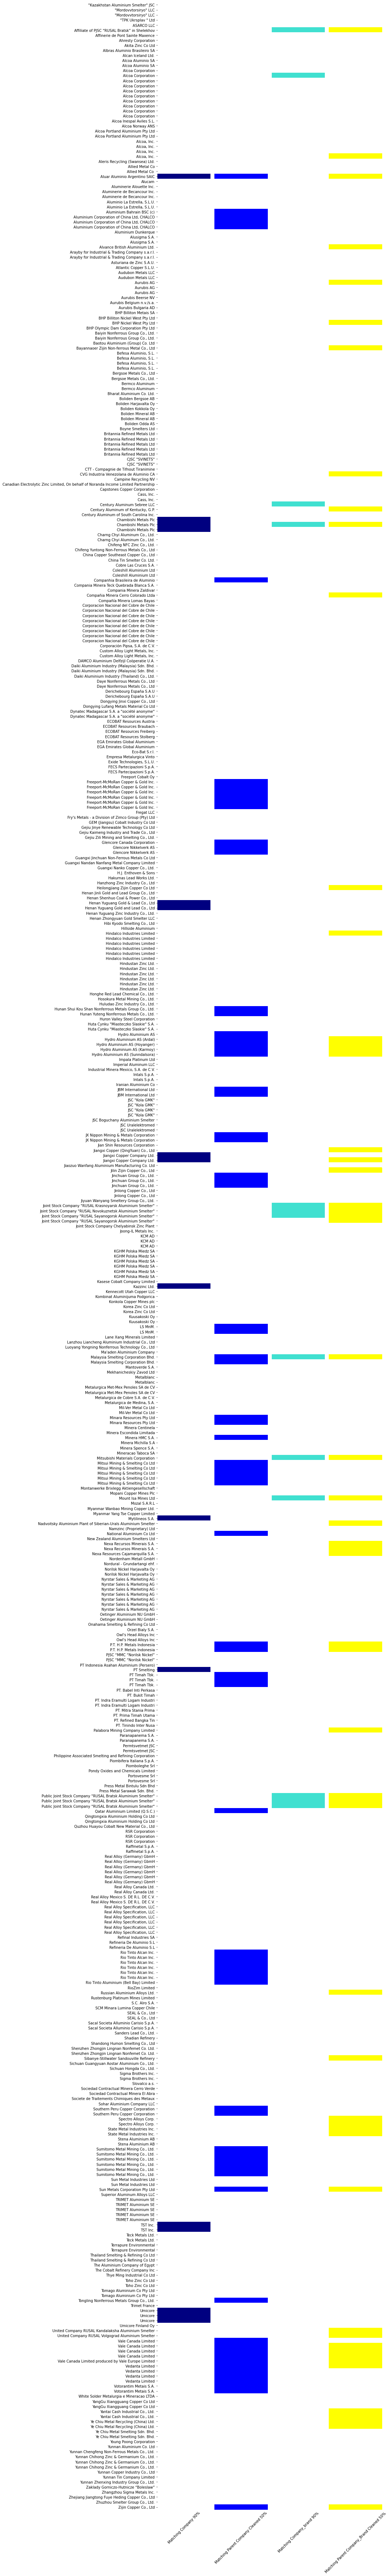

'expanded_heatmap_image.png'

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Mockup data loading for demonstration
# file_path = 'matched_results.csv'
# updated_matched_results = pd.read_csv(file_path)
# Mockup data for demonstration
file_path = 'matched_results.csv'
updated_matched_results = pd.read_csv(file_path)


# Sort the DataFrame by company names (Producer) alphabetically
updated_matched_results = updated_matched_results.sort_values(by='Producer')

# Specify the columns for matching
matched_columns = ['Matching Company 90%', 'Matching Parent Company Cleaned 50%', 'Matching Company_brand 90%', 'Matching Parent Company_Brand Cleaned 50%']

# Create a DataFrame with binary values representing the presence of matches in the specified columns
heatmap_data = updated_matched_results[matched_columns].applymap(lambda x: 1 if pd.notnull(x) else 0)

# Create individual colormaps for each column
colors = [
    ["white", "navy"], 
    ["white", "blue"], 
    ["white", "turquoise"], 
    ["white", "yellow"]
]
colormaps = [LinearSegmentedColormap.from_list(f"colormap_{i}", color, N=2) for i, color in enumerate(colors)]

# Set up the plotting environment
plt.figure(figsize=(15, 100), facecolor='white')

# Iterate over each column and plot individual heatmaps
for i, column in enumerate(matched_columns):
    plt.subplot(1, len(matched_columns), i+1)
    sns.heatmap(heatmap_data[[column]], cmap=colormaps[i], cbar=False, yticklabels=updated_matched_results['Producer'] if i == 0 else False)
    
    plt.xticks([])  # remove x ticks as they are not needed
    plt.xlabel(column, rotation=45)  # rotate x-labels

plt.tight_layout()  # Adjust layout for better appearance

# Save the expanded heatmap with readable y-axis labels as an image file
expanded_heatmap_image_path = "expanded_heatmap_image.png"
plt.savefig(expanded_heatmap_image_path, dpi=300, facecolor='white')

plt.show()

expanded_heatmap_image_path


Enter the company name: Nornilsk
Searching matches for Nornilsk and its subsidiaries
The listed subsidiaries are ['Norilsk Nickel', 'Interros', 'UC RUSAL', 'En+ Group', 'Gazprombank', 'Crédit Agricole', 'Morgan Stanley', 'UBS', 'Sberbank']


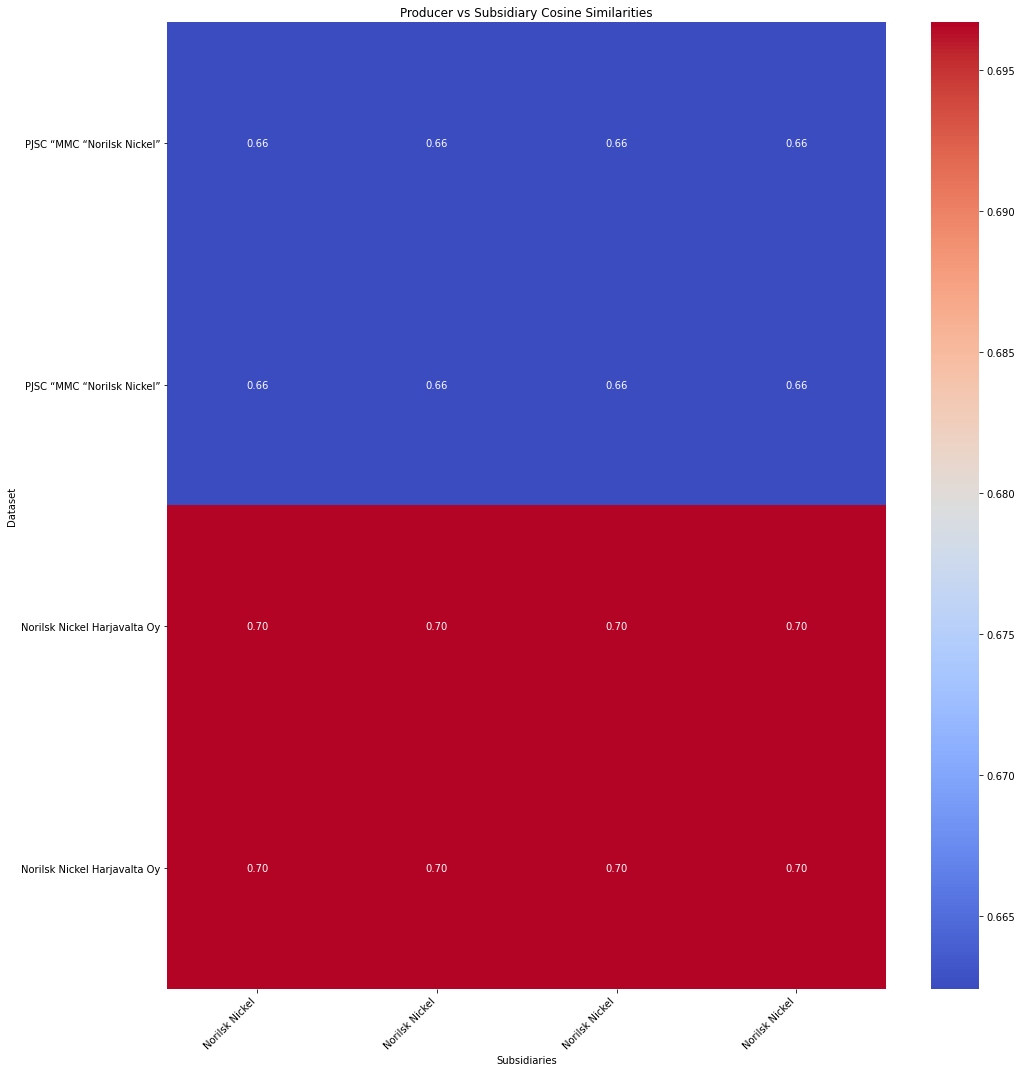

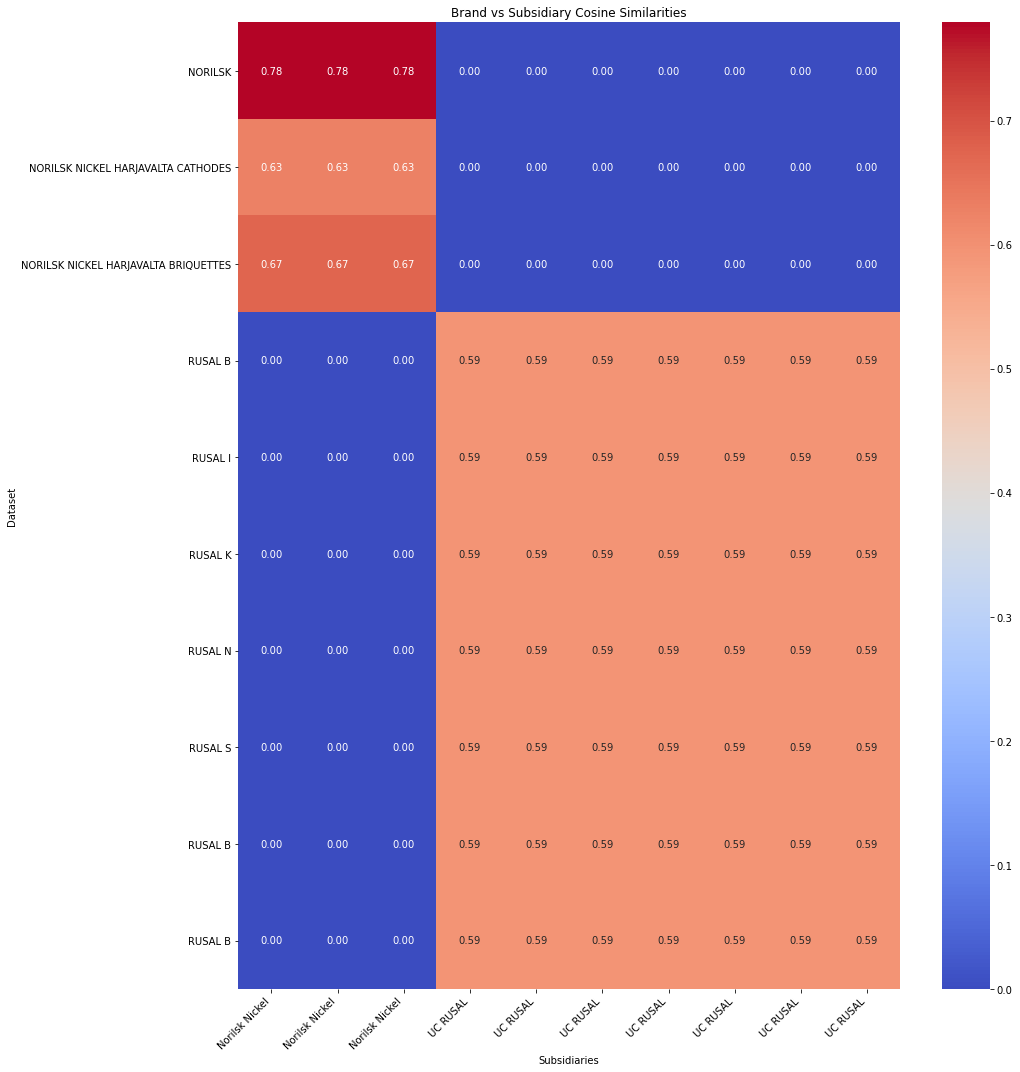

In [15]:
import os
import openai
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Set the OpenAI API key
openai.api_key = os.environ.get("OPENAI_API_KEY")


# Prompt for the company name
company_name = input("Enter the company name: ")
print(f"Searching matches for {company_name} and its subsidiaries")

# Send the prompt to the API
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": "Data Engineer creating lists to use in an app later. Format the list as a python list always."
        },
        {
            "role": "user",
            "content": f"List all of the subsidiaries, holdings, partners and owners of the company {company_name} as a list in python with no other supporting text. Only the list in a usable format with no line breaks."
        }
    ],
    temperature=1,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

# Extract the list of subsidiaries from the response
subsidiaries = eval(response['choices'][0]['message']['content'])
print(f"The listed subsidiaries are {subsidiaries}")
# Load the trimmed_data.csv
data_cleaned = pd.read_csv('trimmed_data.csv')
data_cleaned['Producer'] = data_cleaned['Producer'].fillna('')

# Create a temporary DataFrame using the retrieved subsidiaries
company_temp_df = pd.DataFrame({
    'Company': subsidiaries,
    'Parent Company': [company_name] * len(subsidiaries)
})




# Initialize the vectorizer
vectorizer = TfidfVectorizer()

def calculate_similarity_matrix(combined_text, vectorizer):
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    vectors_a = tfidf_matrix[:len(company_temp_df)]
    vectors_b = tfidf_matrix[len(company_temp_df):]
    return cosine_similarity(vectors_b, vectors_a)

# Run the similarity calculation process using the retrieved subsidiaries
combined_text_companies = pd.concat([company_temp_df['Company'], data_cleaned['Producer']], ignore_index=True)
similarity_matrix_producers = calculate_similarity_matrix(combined_text_companies, vectorizer)

combined_text_brand = pd.concat([company_temp_df['Company'], data_cleaned['Brand']], ignore_index=True)
similarity_matrix_brands = calculate_similarity_matrix(combined_text_brand, vectorizer)
def heatmap_similarity(similarity_matrix, labels_a, labels_b, title):
    # Filter the matrix and labels to show only entries with values > 0
    rows, cols = np.where(similarity_matrix > 0.50)
    if not len(rows):
        print(f"No high similarities found for {title}.")
        return

    filtered_matrix = similarity_matrix[rows][:, cols]
    filtered_labels_a = [labels_a[i] for i in cols]
    filtered_labels_b = [labels_b[i] for i in rows]

    plt.figure(figsize=(15, 15))
    sns.heatmap(filtered_matrix, cmap='coolwarm', annot=True, xticklabels=filtered_labels_a, yticklabels=filtered_labels_b, fmt=".2f")
    
    plt.title(title)
    plt.xlabel('Subsidiaries')
    plt.ylabel('Dataset')
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

# Displaying the heatmaps
heatmap_similarity(similarity_matrix_producers, company_temp_df['Company'], data_cleaned['Producer'], 'Producer vs Subsidiary Cosine Similarities')
heatmap_similarity(similarity_matrix_brands, company_temp_df['Company'], data_cleaned['Brand'], 'Brand vs Subsidiary Cosine Similarities')


In [16]:
import os
import openai
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Set the OpenAI API key
openai.api_key = "os.environ.get("OPENAI_API_KEY")"


# Prompt for the company name
company_name = input("Enter the company name: ")
print(f"Searching matches for {company_name} and its subsidiaries")

# Send the prompt to the API
response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": "Data Engineer creating lists to use in an app later."
        },
        {
            "role": "user",
            "content": f"List all of the subsidiaries of the company {company_name} as a list in python with no other supporting text. Only the list in a usable format with no line breaks."
        }
    ],
    temperature=1,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

# Extract the list of subsidiaries from the response
subsidiaries = eval(response['choices'][0]['message']['content'])
print(f"The listed subsidiaries are {subsidiaries}")
# Load the trimmed_data.csv
data_cleaned = pd.read_csv('trimmed_data.csv')
data_cleaned['Producer'] = data_cleaned['Producer'].fillna('')

# Create a temporary DataFrame using the retrieved subsidiaries
company_temp_df = pd.DataFrame({
    'Company': subsidiaries,
    'Parent Company': [company_name] * len(subsidiaries)
})

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Define the create_matching_column function
def create_matching_column(combined_text, vectorizer, similarity_threshold, column_name):
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    vectors_a = tfidf_matrix[:len(company_temp_df)]
    vectors_b = tfidf_matrix[len(company_temp_df):]
    similarities = cosine_similarity(vectors_b, vectors_a)
    matching_column = [company_temp_df[column_name].iloc[np.argmax(row)] if max(row) > similarity_threshold else None for row in similarities]
    return matching_column

# Run the matching process using the retrieved subsidiaries
combined_text_companies = pd.concat([company_temp_df['Company'], data_cleaned['Producer']], ignore_index=True)
data_cleaned['Matching Company 60%'] = create_matching_column(combined_text_companies, vectorizer, 0.60, 'Company')
combined_text_brand = pd.concat([company_temp_df['Company'], data_cleaned['Brand']], ignore_index=True)
data_cleaned['Matching Parent Company_Brand Cleaned 60%'] = create_matching_column(combined_text_brand, vectorizer, 0.6, 'Parent Company')


# Filter the DataFrame to display only the rows with matches
matches_exist = data_cleaned[data_cleaned['Matching Company 60%'].notna()]
matches_exist2 = data_cleaned[data_cleaned['Matching Parent Company_Brand Cleaned 60%'].notna()]

# Print the resulting DataFrame with only matches
print(f"This is a list of matches for {company_name} based on the producers listed in the document \n{matches_exist}")
print(f"this is a list of matches for {company_name} based on the brands listed in the document \n{matches_exist2}")

Enter the company name: Freeport McMoran
Searching matches for Freeport McMoran and its subsidiaries
The listed subsidiaries are ['PT Freeport Indonesia', 'Cerro Verde', 'El Abra', 'Atlantic Copper', 'Safford', 'Tenke Fungurume', 'Morenci', 'Sierrita', 'Bagdad', 'Chino', 'Rosemont', 'Grasberg Block Cave', 'Grasberg']
This is a list of matches for Freeport McMoran based on the producers listed in the document 
                                   Producer Brand          material  \
8       Sociedad Contractual Minera El Abra  ABRA  Copper - Grade A   
77  Sociedad Contractual Minera Cerro Verde  SMCV  Copper - Grade A   
89                   Atlantic Copper S.L.U.   FMS  Copper - Grade A   

    Country/Region Matching Company 60%  \
8            Chile              El Abra   
77            Peru          Cerro Verde   
89           Spain      Atlantic Copper   

   Matching Parent Company_Brand Cleaned 60%  
8                           Freeport McMoran  
77                                 

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np

# 1) Load the Data
company_list = pd.read_excel('Data (2).xlsx')
company_list['Company'] = company_list['Company'].astype(str).fillna('')

# 2) Create Parent Company Column
def extract_parent_company(value):
    matches = re.findall(r'\(([^)]+)\)', value)
    for match in matches:
        if match not in ['Australia', 'Uk', 'Europe', 'Holdings', 'the', 'Myanmar', 'U.K.', 'Thailand', 'Switzerland','Sales']:
            return match
    return None

company_list['Parent Company'] = company_list['Company'].apply(extract_parent_company)

# 3) Data Cleaning
company_list['Parent Company'] = company_list['Parent Company'].apply(lambda x: x.replace("part of", "").replace("formerly", "").strip() if pd.notnull(x) else x)

# Function to create the matching column based on highest value
def create_matching_column(combined_text, vectorizer, column_name):
    tfidf_matrix = vectorizer.fit_transform(combined_text)
    vectors_a = tfidf_matrix[:len(company_list)]
    vectors_b = tfidf_matrix[len(company_list):]
    similarities = cosine_similarity(vectors_b, vectors_a)

    matching_column = []
    matching_value = []

    for row in similarities:
        highest_index = np.argmax(row)
        highest_value = row[highest_index]
        matching_value.append(highest_value)
        matching_column.append(company_list[column_name].iloc[highest_index])

    return matching_column, matching_value

vectorizer = TfidfVectorizer()

# Load data_cleaned DataFrame
data_cleaned = pd.read_csv('trimmed_data.csv')
data_cleaned['Producer'] = data_cleaned['Producer'].fillna('')

# 4) Process for Creating the Matching Companies Column based on highest value
combined_text_companies = pd.concat([company_list['Company'], data_cleaned['Producer']], ignore_index=True)
matching_companies, matching_values = create_matching_column(combined_text_companies, vectorizer, 'Company')
data_cleaned['Matching Company Highest'] = matching_companies
data_cleaned['Matching Company Highest Value'] = matching_values

# 5) Process for Creating the Matching Cleaned Parent Companies based on highest value
combined_text_parent_cleaned = pd.concat([company_list['Parent Company'].fillna(''), data_cleaned['Producer']], ignore_index=True)
matching_parent_companies_cleaned, matching_parent_values_cleaned = create_matching_column(combined_text_parent_cleaned, vectorizer, 'Parent Company')
data_cleaned['Matching Parent Company Cleaned Highest'] = matching_parent_companies_cleaned
data_cleaned['Matching Parent Company Cleaned Highest Value'] = matching_parent_values_cleaned

# 6) Similar process for 'Brand' column with highest value
combined_text_companies = pd.concat([company_list['Company'], data_cleaned['Brand']], ignore_index=True)
matching_companies_brand, matching_values_brand = create_matching_column(combined_text_companies, vectorizer, 'Company')
data_cleaned['Matching Company_Brand Highest'] = matching_companies_brand
data_cleaned['Matching Company_Brand Highest Value'] = matching_values_brand

# 7) Process for Creating the Matching Cleaned Parent Companies for 'Brand' based on highest value
combined_text_parent_cleaned = pd.concat([company_list['Parent Company'].fillna(''), data_cleaned['Brand']], ignore_index=True)
matching_parent_companies_brand_cleaned, matching_parent_values_brand_cleaned = create_matching_column(combined_text_parent_cleaned, vectorizer, 'Parent Company')
data_cleaned['Matching Parent Company_Brand Cleaned Highest'] = matching_parent_companies_brand_cleaned
data_cleaned['Matching Parent Company_Brand Cleaned Highest Value'] = matching_parent_values_brand_cleaned

# Save the updated data_cleaned DataFrame
data_cleaned.to_csv('matched_results.csv', index=False)


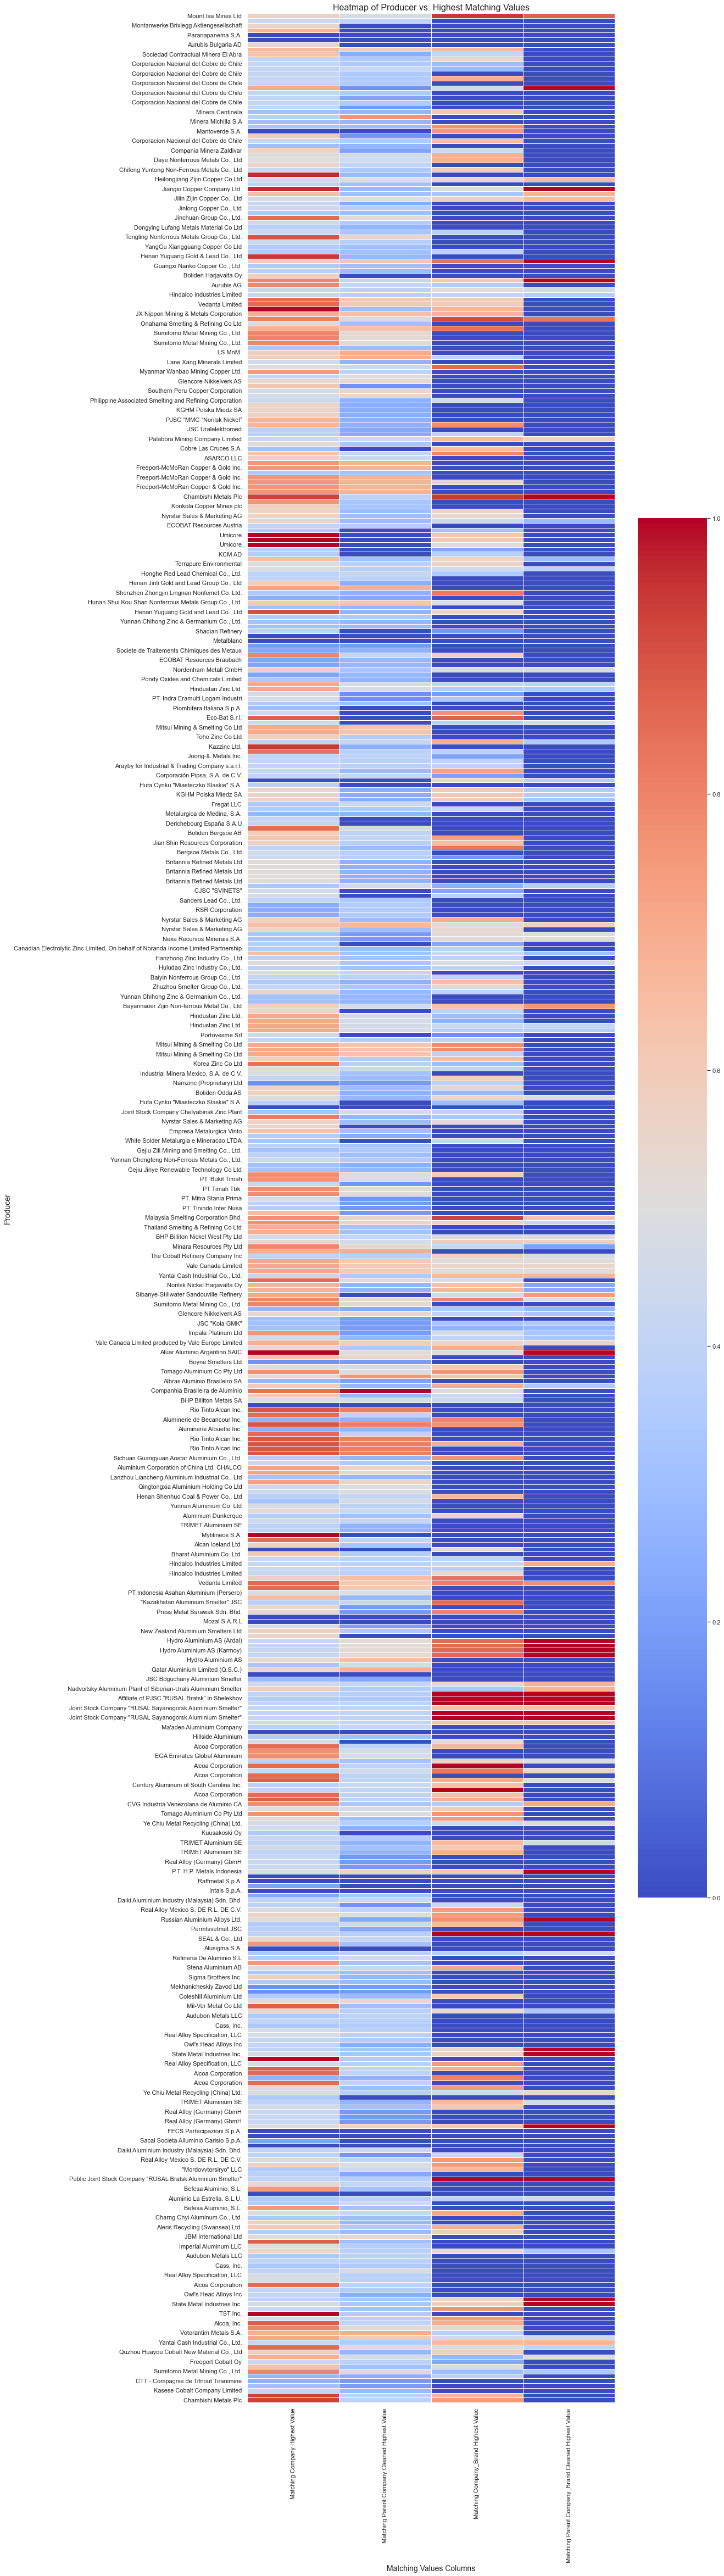

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = 'matched_results.csv'  # Change this to your file path
df = pd.read_csv(file_path)

# Select columns for the heatmap
matching_value_columns = [
    "Matching Company Highest Value",
    "Matching Parent Company Cleaned Highest Value",
    "Matching Company_Brand Highest Value",
    "Matching Parent Company_Brand Cleaned Highest Value"
]
heatmap_data = df[['Producer'] + matching_value_columns]

# Set the plot style and background color
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "white"})

# Create the heatmap
plt.figure(figsize=(15, 80))  # Increase the figure size for better readability
sns.heatmap(heatmap_data.set_index('Producer'), annot=False, cmap="coolwarm", linewidths=.5)

# Add title and labels
plt.title("Heatmap of Producer vs. Highest Matching Values", fontsize=16)
plt.xlabel("Matching Values Columns", fontsize=14)
plt.ylabel("Producer", fontsize=14)

# Show the plot
plt.show()
